# Take Off Performance

The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations
1. Wind velocity component along the runway:
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

2. Take off groundspeed with wind:
$$
V_{\text{TO}_w} = V_\text{TO} - V_w
$$

3. Standard take off distance corrected for wind:
$$
S_{1_{\text{std}}} = S_{1_w}\left(1+\frac{V_W}{V_{\text{TOW}}}\right)^{1.85}
$$

4. Standard take off distance corrected for slope:
$$
S_{1_{\text{std}}} = \frac{S_{1_\text{SL}}}{\left(1-\frac{2gS_{1_\text{SL}}}{V_{\text{TO}}^2}\sin\theta\right)}
$$

5. Density Ratio
$$
\sigma = 9.625\frac{P_a}{T_a}
$$

6. Standard take off distance corrected for thrust, weight, density (for jet aircraft):
$$
S_{1_\text{std}}=S_{1_\text{Test}}\left(\frac{W_\text{Test}}{W_\text{Std}}\right)^{2.3}\left(\frac{\sigma_\text{Test}}{\sigma_\text{Std}}\right)\left(\frac{T_{N_\text{Test}}}{T_{N_\text{Std}}}\right)^{1.3}
$$

<!-- TODO: Check which of these air distance calculations I need -->
7. Standard air distance corrected for thrust, weight, density (for jet aircraft):
$$
S_{2_\text{std}}=S_{2_\text{Test}}\left(\frac{W_\text{Test}}{W_\text{Std}}\right)^{2.3}\left(\frac{\sigma_\text{Test}}{\sigma_\text{Std}}\right)^{0.7}\left(\frac{T_{N_\text{Test}}}{T_{N_\text{Std}}}\right)^{1.6}
$$

<!-- TODO: Check which of these air distance calculations I need -->
8. Standard air distance corrected for wind
$$
S_{2_\text{std}} = S_{2_w}+\Delta S_2 = S_{2_w}+V_wt
$$

### Variables

- $ g $: Gravitational acceleration $(\text{ft/s}^2)$
- $ P_a $: Ambient pressure $(\text{psf})$
- $ \theta $: Runway slope angle $(\text{deg})$
- $ S_{1_{SL}} $: Takeoff distance, brake release to lift off, sloping runway $(\text{ft})$
- $ S_{1_{\text{std}}} $: Standard takeoff distance, brake release to lift off $(\text{ft})$
- $ S_{1_{\text{Test}}} $: Test takeoff distance, brake release to lift off $(\text{ft})$
- $ S_{1_w} $: Takeoff distance, brake release to lift off, with respect to wind $(\text{ft})$
- $ \sigma_{\text{std}} $: Standard density ratio
- $ \sigma_{\text{Test}} $: Test density ratio
- $ T_a $: Ambient temperature $(\degree K)$
- $ T_{N_{\text{std}}} $: Standard net thrust $(\text{lb})$
- $ T_{N_{\text{Test}}} $: Test net thrust $(\text{lb})$
- $ V_{\text{TO}} $: Takeoff ground speed $(\text{ft/s})$
- $ V_{\text{TOw}} $: Takeoff ground speed with respect to wind $(\text{ft/s})$
- $ V_w $: Wind velocity $(\text{ft/s})$
- $ W_{\text{std}} $: Standard weight $(\text{lb})$
- $ W_{\text{Test}} $: Test weight $(\text{lb})$
- $S_{2}$: Take off distance, lift off to 50ft $(\text{ft})$
- $S_{2std}$: Standard take off distance, lift off to 50ft $(\text{ft})$
- $S_{2w}$: Take off distance, lift off to 50ft, with respect to wind $(\text{ft})$
- $\Delta S_{2}$: Change in $S_2$, equal to $tV_w$ $(\text{ft})$
- $t$: Time to climb 50ft.

## Pilot's Data
1. Ground roll distance (brake release to lift off) (ft).
2. Wind velocity and direction relative to the runway (ft/s / degrees).
3. Lift off airspeed $V_o$ (correct for position and instrument error) (ft/s).
4. Temperature $T_a$ (°K).
5. Weight $W$ (lb).
6. Pressure altitude $H_P$ (ft).
7. Runway slope $\theta$ (deg).
8. Time to climb to 50ft from liftoff $t$ (s)

## Order of Analysis

| Step | Parameter             | Notation      | Formula    | Units | Remarks                                   |
|------|------------------------|---------------|------------|-------|-------------------------------------------|
| 1    | Wind component         | $ V_w $    | Eq 9.38    | ft/s  |                                           |
| 2    | Takeoff ground speed   | $ V_{\text{TOw}} $ | Eq 9.19    | ft/s  |                                           |
| 3    | Ground roll            | $ S_{1_{\text{std}}} $ | Eq 9.23    | ft    | Wind corrected                            |
| 4    | Ground roll            | $ S_{1_{\text{std}}} $ | Eq 9.27    | ft    | Slope corrected                           |
| 5    | Density ratio          | $ \sigma $ | Eq 9.39    |       |                                           |
| 6    | Ground roll            | $ S_{1_{\text{std}}} $ | Eq 9.28    | ft    | Thrust, weight, density corrected; $ T_N $ from thrust stand data |
| 7    | Air distance            | $ S_{2_{\text{std}}} $ | Eq 9.29    | ft    | Thrust, weight, density corrected                           |
| 8   | Air distance            | $ S_{2_{\text{std}}} $ | Eq 9.24    | ft    | Wind corrected                            |

## Python Code

In [72]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

# Constants
g = 32.17  # ft/s^2

### Functions

#### Wind Component
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

In [73]:
# Step 1
def headwind_component(v, relative_angle):
    component = v * np.cos(np.radians(relative_angle))
    # If the result is very close to zero, set it to zero, due floating point errors
    tolerance = 1e-10
    if abs(component) < tolerance:
        return 0.0
    return component

#### Take off Groundspeed
$$
V_{\text{TO}_w} = V_\text{TO} - V_w
$$

In [74]:
# Step 2
def takeoff_groundspeed(v_to, v_w):
    return v_to - v_w

#### Standard take off distance corrected for wind
$$
S_{1_{\text{std}}} = S_{1_w}\left(1+\frac{V_W}{V_{\text{TOW}}}\right)^{1.85}
$$

In [75]:
# Step 3
def wind_corrected_ground_roll(s_1w, v_w, v_tow):
    return s_1w * (1 + (v_w / v_tow)) ** 1.85

#### Standard take off distance corrected for slope
$$
S_{1_{\text{std}}} = \frac{S_{1_\text{SL}}}{\left(1-\frac{2gS_{1_\text{SL}}}{V_{\text{TO}}^2}\sin\theta\right)}
$$

In [76]:
# Step 4
def slope_corrected_ground_roll(s_1sl, v_to, theta):
    return s_1sl / (1 - (2 * g * s_1sl) / (v_to**2) * np.sin(np.radians(theta)))

#### Density Ratio
$$
\sigma = 9.625 \frac{P_a}{T_a}
$$

In [77]:
# Step 5
def density_ratio(p_a, p_t):
    return 9.625 * (p_a / p_t)

#### Standard take off distance corrected for thrust, weight, and density
$$
S_{1_\text{std}}=S_{1_\text{Test}}\left(\frac{W_\text{Test}}{W_\text{Std}}\right)^{2.3}\left(\frac{\sigma_\text{Test}}{\sigma_\text{Std}}\right)\left(\frac{T_{N_\text{Test}}}{T_{N_\text{Std}}}\right)^{1.3}
$$

In [78]:
# Step 6
def thrust_weight_density_corrected_ground_roll(
    s_1t, w_s, w_t, sigma_t, sigma_s, T_Nt, T_Ns
):
    return s_1t * (w_s / w_t) ** 2.3 * (sigma_t / sigma_s) * (T_Nt / T_Ns) ** 1.3

#### Standard air distance corrected for 
$$
S_{2_\text{std}}=S_{2_\text{Test}}\left(\frac{W_\text{Test}}{W_\text{Std}}\right)^{2.3}\left(\frac{\sigma_\text{Test}}{\sigma_\text{Std}}\right)^{0.7}\left(\frac{T_{N_\text{Test}}}{T_{N_\text{Std}}}\right)^{1.6}
$$

In [79]:
# Step 7
# TODO: Add

#### Standard air distance corrected for wind
$$
S_{2_\text{std}} = S_{2_w}+V_wt
$$

In [80]:
# Step 8
def wind_corrected_air_distance(s_2w, v_w, t):
    return s_2w + t * v_w

#### Haversine Distance
For calculating the great circle distance between two latitude and longitudes

In [81]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in meters
    R = 6371000

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in meters
    distance_meters = R * c

    # Convert distance from meters to feet
    distance_feet = distance_meters * 3.28084

    return distance_feet


# distance = haversine_distance(start_lat, start_lon, end_lat, end_lon)
# print(f"Distance: {distance:.2f} feet")

### Load Data

In [82]:
df_takeoff = pd.read_excel("./demo_data/takeoff.xlsx")

In [83]:
# TODO: Change speeds to feet per second

initial_alt = df_takeoff.iloc[0]["ASL"]
initial_lat = df_takeoff.iloc[0]["Lat"]
initial_lon = df_takeoff.iloc[0]["Lon"]
# Find index of when RadAlt is greater than 4.8 (it reads ~4.6-4.7 on the ground)
liftoff_index = df_takeoff[df_takeoff["radalt"] > 4.8].index[0]
lat_at_liftoff = df_takeoff.loc[liftoff_index, "Lat"]
lon_at_liftoff = df_takeoff.loc[liftoff_index, "Lon"]
ias_at_liftoff = df_takeoff.loc[liftoff_index, "IAS"]
ias_at_liftoff_fps = atm.kts_to_fps(ias_at_liftoff)
time_at_liftoff = df_takeoff.loc[liftoff_index, "Time"]

fifty_ft_index = df_takeoff[df_takeoff["radalt"] > 54.8].index[0]
ias_at_50 = df_takeoff.loc[fifty_ft_index, "IAS"]
ias_at_50_fps = atm.kts_to_fps(ias_at_50)
lat_at_50 = df_takeoff.loc[fifty_ft_index, "Lat"]
lon_at_50 = df_takeoff.loc[fifty_ft_index, "Lon"]
time_at_50 = df_takeoff.loc[fifty_ft_index, "Time"]

# Calculate the distance between the initial position and the position at lift off and 50 ft
ground_roll = haversine_distance(
    initial_lat, initial_lon, lat_at_liftoff, lon_at_liftoff
)
air_distance = haversine_distance(lat_at_liftoff, lon_at_liftoff, lat_at_50, lon_at_50)

# Calculate the time it took to lift off and reach 50 ft
time_from_liftoff_to_50 = time_at_50 - time_at_liftoff

# Made up wind
wind_speed = 0  # knots
# TODO: Change wind speed to feet per second
wind_relative_angle = 0  # degrees

### Test Parameters

In [84]:
# Aircraft data L-39
ZFW = 7752  # lb
fuel = 2210  # lb
# w_t = ZFW + fuel
w_t = 9500
w_s = 14000  # lb

# Airfield Data
elevation = 0  # ft MSL 38
slope = 0  # degrees

# Customer Requirements
cr_takeoff_distance = 7000  # ft
confidence = 0.95

### Data Analysis

In [85]:
headwind = headwind_component(wind_speed, wind_relative_angle)
to_gs = takeoff_groundspeed(ias_at_liftoff_fps, headwind)
s_sw = wind_corrected_ground_roll(ground_roll, headwind, to_gs)
s_sl = slope_corrected_ground_roll(s_sw, ias_at_liftoff_fps, slope)
# TODO: Calculate pressure at the initial altitude in lb/ft^2
sigma = density_ratio(atm.get_std_delta(initial_alt), atm.get_std_theta(initial_alt))
sigma_t = atm.get_std_sigma(initial_alt)
sigma_s = atm.get_std_sigma(initial_alt)
s_s = thrust_weight_density_corrected_ground_roll(
    s_sl, w_s, w_t, sigma_t, sigma_s, 1, 1
)
s_2 = wind_corrected_air_distance(air_distance, headwind, time_from_liftoff_to_50)

print(f"Test Ground roll was : {ground_roll:.2f} feet")
print(f"Standardised Ground roll: {s_s:.2f} feet")
print(f"Test Air distance: {air_distance:.2f} feet")
print(f"Standardised Air distance was : {s_2:.2f} feet")

Test Ground roll was : 1579.60 feet
Standardised Ground roll: 3853.70 feet
Test Air distance: 678.42 feet
Standardised Air distance was : 678.42 feet


Test Ground roll was : 1579.60 feet

Standardised Ground roll: 3853.70 feet

Test Air distance: 678.42 feet

Standardised Air distance was : 678.42 feet


#### Plot

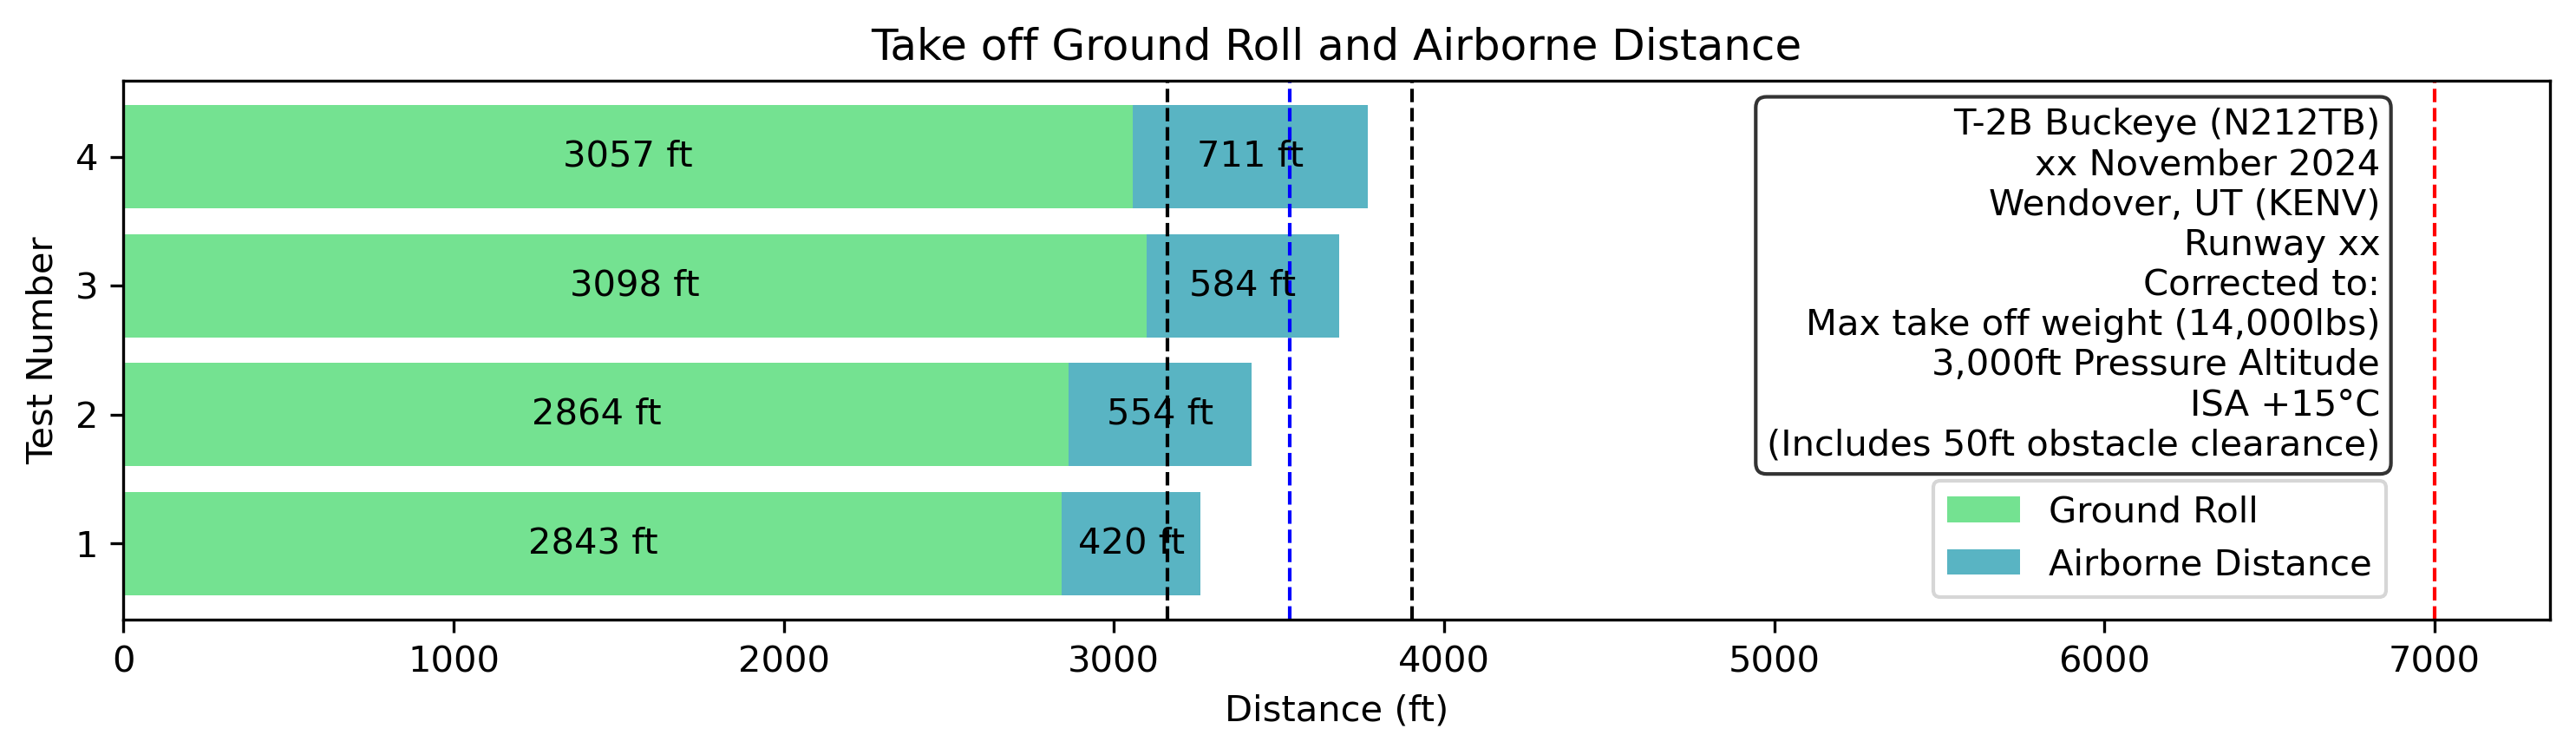

In [86]:
plt.figure(figsize=(10, 3), dpi=300)
# Sample data (replace with your actual data)
ground_rolls = np.array([2843, 2864, 3098, 3057])  # Ground roll distances in feet
airborne_distances = np.array([420, 554, 584, 711])  # Airborne distances in feet

ground_roll_color = "#74E291"
airborne_distance_color = "#59B4C3"

plt.barh(
    range(1, len(ground_rolls) + 1),
    ground_rolls,
    color=ground_roll_color,
    label="Ground Roll",
)
plt.barh(
    range(1, len(ground_rolls) + 1),
    airborne_distances,
    left=ground_rolls,
    color=airborne_distance_color,
    label="Airborne Distance",
)

for i, (gr, ad) in enumerate(zip(ground_rolls, airborne_distances)):
    plt.text(gr / 2, i + 1, f"{gr} ft", ha="center", va="center", color="black")
    plt.text(gr + ad / 2, i + 1, f"{ad} ft", ha="center", va="center", color="black")

# Add vertical red line at 7000 ft
plt.axvline(x=cr_takeoff_distance, color="red", linestyle="--", linewidth=1)

# Condfidence intervals
# TODO: UPDATE
plt.axvline(x=3532.75, color="blue", linestyle="--", linewidth=1)
plt.axvline(x=3161.22, color="black", linestyle="--", linewidth=1)
plt.axvline(x=3904.28, color="black", linestyle="--", linewidth=1)

details = (
    "T-2B Buckeye (N212TB)\n"
    "xx November 2024\n"
    "Wendover, UT (KENV)\n"
    "Runway xx\n"
    "Corrected to:\n"
    "Max take off weight (14,000lbs)\n"
    "3,000ft Pressure Altitude\n"
    "ISA +15°C\n"
    "(Includes 50ft obstacle clearance)"
)
# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.93,
    0.95,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xlabel("Distance (ft)")
plt.ylabel("Test Number")
plt.title("Take off Ground Roll and Airborne Distance")
plt.legend(loc="center right", bbox_to_anchor=(0.94, 0.15))

# Show plot
plt.tight_layout()

# Save the plot
# plt.savefig(f"./plots/takeoff_perf.png")

plt.show()

#### Confidence Intervals

In [87]:
# Get 95% confidence interval
total_distance = ground_rolls + airborne_distances

# Calculate the mean
mean = np.mean(total_distance)
# Calculate the standard error of the mean
sem = stats.sem(total_distance)
# Calculate the degrees of freedom (aka Alpha)
n = len(total_distance)
df = n - 1

t_critical = stats.t.ppf((1 + confidence) / 2, df)
margin_of_error = t_critical * sem
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(f"Mean takeoff distance (over 50 ft): {mean:.2f} ft +/- {margin_of_error:.2f} ft")
print(
    f"95% confidence interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) ft"
)

Mean takeoff distance (over 50 ft): 3532.75 ft +/- 371.53 ft
95% confidence interval: (3161.22, 3904.28) ft


# NTPS
## Wind Corrections

- Headwind Velocity ($V_w$)
- Liftoff airspeed ($V_LO$)
- Ground speed at take off $V_g$
- Take off ground distance ($S_g$)
- Zero wind Take off ground roll ($S_{gt}$)
- With wind Take off ground roll ($S_{gw}$)
$$
\text{Take off ground roll corrected for wind - empirical}\\
S_{gt} = S_{gw}\left(\frac{V_{LO}}{V_{LO}-V_w}\right)^{1.85}
$$

- Time to climb to 50ft ($t$)
- Take off air distance ($S_a$)
- Take off air distance with wind ($S_aw$)
- Take off air distance with zero wind ($S_at$)
- Change in distanced caused by wind velocity $\Delta S_\alpha$
$$
\text{Take off air distance corrected for wind}\\
S_\alpha = S_{aw}+V_wt
$$

## Runway Slope Corrections

If thrust know, $F_{ex}$ average excess thrust
$$
\text{Take off ground roll correction for runway slope}\\
S_gF_{ex}=S_{gt}(F_{ex}-W\sin\theta) \\
\text{or}\\
S_g = S_{gt}\left(1-\frac{W}{F_{ex}}\sin\theta\right)
$$

If thrust not known:
$$
S_g = \frac{S_{gt}}{\left(1+\frac{2gS_{gt}}{V_{LO}^2}\sin\theta\right)}
$$

## Thrust, Weight, and Density Corrections

For light jets:
$$
S_{gs}=S_{gt}\left(\frac{W_s}{W_t}^{2.6}\right)\left(\frac{\sigma_t}{\sigma_s}\right)\left(\frac{F_{nt}}{F_{ns}}\right)^{0.7}
$$
Where:
- $F_{nt}=T_{ot}=$ Avg. Test Net Thrust (approx. 0.94xstatic thrust @ test conditions)
- $F_{ns}=T_{os}=$ Avg. Standard Net Thrust (approx. 0.94xstatic thrust @ std. conditions)

::Does this mean I can use the test temp vs standard day temp for that elevation?::